Raw data shape: (34272, 207)
Extracted features shape: (7093890, 6)
Features Scaled and Saved.
Clustered K-Means with best K and saved the model
Davies-Bouldin Index: 1.3532375411025972


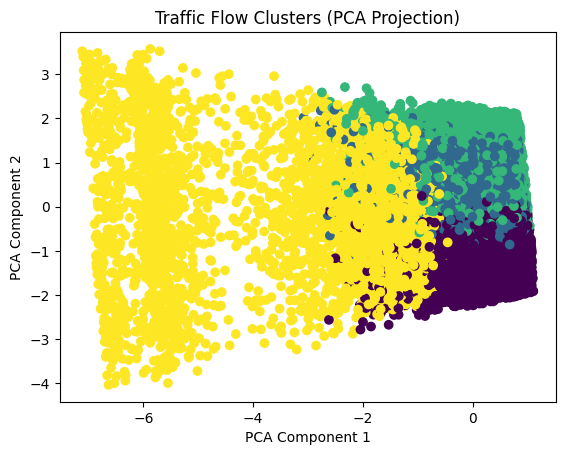

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [3]:
# Urban Traffic Flow Clustering using METR-LA Dataset (Optimized Vectorized Version + Silhouette-based K selection)
# --------------------------------------------------
# This notebook loads METR-LA traffic speed data, extracts features,
# performs clustering, evaluates the model, and saves it for reuse.

# ================================
# 1. Imports
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import joblib
import pickle

# ================================
# 2. Load Dataset (.h5 support)
# ================================
data_path = "METR-LA.h5"  # change path if needed

df = pd.read_hdf(data_path)
print("Raw data shape:", df.shape)

# Handle missing values
df = df.interpolate().bfill()

# ================================
# 3. Feature Extraction (Vectorized)
# ================================
def extract_features_vectorized(data, window_size=3):
    avg_speed = data.rolling(window=window_size).mean().iloc[window_size-1:]
    speed_std = data.rolling(window=window_size).std().iloc[window_size-1:]
    speed_change = data.diff(periods=window_size-1).iloc[window_size-1:]

    timestamps = data.index[window_size-1:]
    time_of_day = timestamps.hour + timestamps.minute / 60.0
    day_of_week = timestamps.weekday

    n_sensors = data.shape[1]
    time_of_day_col = np.tile(time_of_day.values, n_sensors)
    day_of_week_col = np.tile(day_of_week.values, n_sensors)

    sensor_ids = np.repeat(data.columns.values, len(timestamps))
    avg_speed_col = avg_speed.values.flatten()
    speed_std_col = speed_std.values.flatten()
    speed_change_col = speed_change.values.flatten()

    features_df = pd.DataFrame({
        "sensor_id": sensor_ids,
        "avg_speed": avg_speed_col,
        "speed_std": speed_std_col,
        "speed_change": speed_change_col,
        "time_of_day": time_of_day_col,
        "day_of_week": day_of_week_col
    })

    return features_df

features_df = extract_features_vectorized(df, window_size=3)
print("Extracted features shape:", features_df.shape)

# ================================
# 4. Feature Scaling
# ================================
X = features_df.drop(columns=["sensor_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler.joblib")
print("Features Scaled and Saved.")

# ================================
# 5. Silhouette-based K Selection (Low-Risk Upgrade)
# ================================
# sil_scores = {}
# for k_test in range(2, 8):
#     kmeans_test = KMeans(n_clusters=k_test, random_state=42)
#     labels_test = kmeans_test.fit_predict(X_scaled)
#     sil_scores[k_test] = silhouette_score(X_scaled, labels_test)
#     print(f"K={k_test}, Silhouette Score={sil_scores[k_test]:.4f}")

# print("Calculated Silhouette Scores.")

# # Plot Silhouette Score vs K
# plt.figure()
# plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
# plt.title('Silhouette Score vs Number of Clusters')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Silhouette Score')
# plt.show()

# # Select best K
# best_k = max(sil_scores, key=sil_scores.get)
# print("Optimal number of clusters based on Silhouette:", best_k)
# print("Selected the best K.")
best_k = 4


# ================================
# 6. Clustering (K-Means) with best K
# ================================
k = best_k
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
features_df["cluster"] = cluster_labels
joblib.dump(kmeans, "kmeans_traffic_model.joblib")
print("Clustered K-Means with best K and saved the model")

# ================================
# 7. Evaluation Metrics
# ================================
# sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)
# print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", db_score)

# ================================
# 8. Visualization
# ================================
sample_size = 100000
idx = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[idx]
cluster_sample = cluster_labels[idx]

pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
X_pca_sample = pca.fit_transform(X_sample)

# plt.show()

# pca = PCA(n_components=2, random_state=42)
# X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=cluster_sample)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title("Traffic Flow Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# ================================
# 9. Spatial Clustering (Spectral)
# ================================
with open("adj_METR-LA.pkl", "rb") as f:
    adj_matrix = pickle.load(f, encoding='latin1')
adj_matrix = np.array(adj_matrix)  # convert to NumPy array
print("Adjacency matrix shape:", adj_matrix.shape)

spectral_spatial = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42)
spatial_labels = spectral_spatial.fit_predict(adj_matrix)
spatial_cluster_map = dict(zip(df.columns, spatial_labels))
features_df["spatial_cluster"] = features_df["sensor_id"].map(spatial_cluster_map)
print("Done with the spectral clustering part.")

# ================================
# 10. Save Final Feature Data
# ================================
features_df.to_csv("traffic_features_with_clusters.csv", index=False)
print("Training complete. Models and features saved.")